In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# M1 L2/3

In [51]:
with open('../python/methods.py', 'r') as file:
    exec(file.read())

In [52]:
samples = pd.read_csv('../sample_sheet.csv')
samples = samples[ samples['Region'] == 'M1_L23' ]

In [53]:
def read_sample_event_data(sample_name, time_shift = 0, event_length = 0.25):
    """
    Reads sample event data.
    
    :param sample_name: Sample identifier.
    :param movement: Whether to read movement or no movement data.
    :param time_shift: How much time to record before the event (negative shift) or after the event
                       (positive shift) (in seconds). If the shift is not possible, will return
                       zero-padded values.
    :param event_length: How much of the event time to return (in seconds). None corresponds to the
                         complete event.
    :return: np.array (number of events x time points)
    """
    import re
    import numpy as np

    animal_id = re.match('(W[0-9]+).*', sample_name).group(1)
    cell_name = re.match('.*(C[0-9]+)', sample_name).group(1)
    
    prefix = f'../output/spontaneous-movement/{animal_id}/{cell_name}'
    
    sample_data = pd.read_pickle(f'{prefix}/vm/filter.pkl')
    sample_events = pd.read_csv(f'{prefix}/events2.csv')

    before_event = time_shift < 0
    time_shift = np.abs(time_shift)

    event_data = []
    for i, event in sample_events.iterrows():
        if before_event:
            start = event['Start'] - time_shift
            
            if start < 0:
                print('Event starts too early, skipping')
                continue
            
            end = event['Start'] + event_length
        else:
            start = event['End'] - event_length
            end = event['End'] + time_shift
            
            if end > np.max(sample_data.times):
                print('Event ends too late, skipping')
                continue

        channel = event['ChannelID']
        channel_data = sample_data.copy().crop(tmin = start, tmax = end).get_data(picks = [channel]).flatten()
        event_data.append(channel_data)

    event_data = np.array(event_data)
    
    return event_data

In [54]:
def read_event_data(sample_ids, time_shift = 0, event_length = 0.25):
    event_data = []
    for sample_id in sample_ids:
        event_data.append(read_sample_event_data(sample_id, time_shift = time_shift, event_length = event_length))
    
    event_data = np.concatenate(event_data)
    return event_data

In [55]:
event_data_before = read_event_data(sample_ids = samples['SID'], time_shift = -0.4, event_length = 0.4)

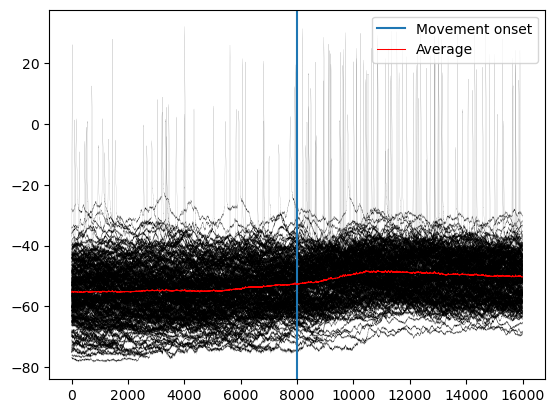

In [56]:
for i in event_data_before:
    plt.plot(i, linewidth = 0.05, color = 'black')

plt.axvline(x = 0.4 * 20000, label = 'Movement onset')
plt.plot(np.mean(event_data_before, axis = 0), linewidth = 0.75, color = 'red', label = 'Average')
plt.legend(loc = 'upper right')
plt.show()

In [57]:
onset_idx = int(0.4 * 20000)
print(f'Average signal before the event: {np.mean(event_data_before[ :, :onset_idx ])}')
print(f'Average signal during the event: {np.mean(event_data_before[ :, onset_idx: ])}')

Average signal before the event: -54.53975152925077
Average signal during the event: -49.76062871088353


In [58]:
event_data_after = read_event_data(sample_ids = samples['SID'], time_shift = 0.25, event_length = 0.4)

Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping
Event ends too late, skipping


Events were not filtered by start position, so a lot are skipped here.

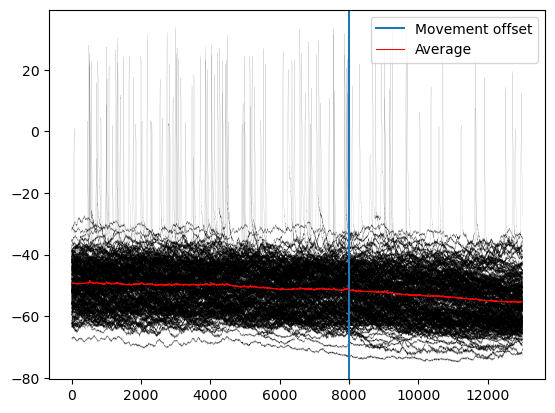

In [59]:
for i in event_data_after:
    plt.plot(i, linewidth = 0.05, color = 'black')
    
plt.axvline(x = 0.4 * 20000, label = 'Movement offset')
plt.plot(np.mean(event_data_after, axis = 0), linewidth = 0.75, color = 'red', label = 'Average')
plt.legend(loc = 'upper right')
plt.show()

In [60]:
offset_idx = int(0.4 * 20000)
print(f'Average signal during the event: {np.mean(event_data_after[ :, :offset_idx ])}')
print(f'Average signal after the event: {np.mean(event_data_after[ :, offset_idx: ])}')

Average signal during the event: -50.168492289333365
Average signal after the event: -53.57034840601699


In [61]:
data_before = event_data_before[ :, :onset_idx ]
data_during_early = event_data_before[ :, onset_idx: ]
data_during_late = event_data_after[ :, :offset_idx ]
data_after = event_data_after[ :, offset_idx: ]

In [62]:
dt = np.concatenate([
    np.mean(data_before, axis = 1),
    np.mean(data_during_early, axis = 1),
    np.mean(data_during_late, axis = 1),
    np.mean(data_after, axis = 1)
])

types = np.concatenate([
    np.repeat('Before', data_before.shape[0]),
    np.repeat('Early event', data_during_early.shape[0]),
    np.repeat('Late event', data_during_late.shape[0]),
    np.repeat('After', data_after.shape[0])
])

assert len(dt) == len(types)

dt = pd.DataFrame({
    'Mean': dt,
    'Type': types
})

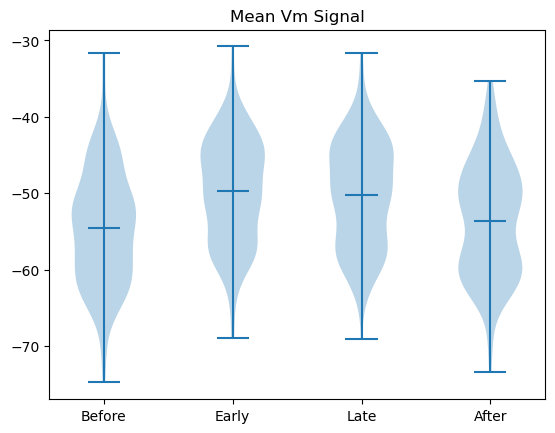

In [63]:
plt.violinplot([
    dt[dt['Type'] == 'Before']['Mean'],
    dt[dt['Type'] == 'Early event']['Mean'],
    dt[dt['Type'] == 'Late event']['Mean'],
    dt[dt['Type'] == 'After']['Mean']
], showmeans = True)

plt.xticks([1, 2, 3, 4], ['Before', 'Early', 'Late', 'After'])
plt.title('Mean Vm Signal')
plt.show()

In [64]:
dt1 = dt[dt['Type'] == 'Before']['Mean']
dt2 = dt[dt['Type'] == 'Early event']['Mean']
t_statistic, p_value = ttest_ind(dt1, dt2)
print('T-statistic:', t_statistic)
print('P-value:', p_value)

T-statistic: -6.726309706429774
P-value: 5.833498266148336e-11


Slight difference between before the event and during the event.

In [65]:
dt1 = dt[dt['Type'] == 'Early event']['Mean']
dt2 = dt[dt['Type'] == 'Late event']['Mean']
t_statistic, p_value = ttest_ind(dt1, dt2)
print('T-statistic:', t_statistic)
print('P-value:', p_value)

T-statistic: 0.5897042478527992
P-value: 0.5557227219092042


No difference between the start of event versus the end of event.

In [66]:
dt1 = dt[dt['Type'] == 'Late event']['Mean']
dt2 = dt[dt['Type'] == 'After']['Mean']
t_statistic, p_value = ttest_ind(dt1, dt2)
print('T-statistic:', t_statistic)
print('P-value:', p_value)

T-statistic: 4.675928449636352
P-value: 4.051972197986002e-06


Slight difference between during the event and after the event.